In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
from qiskit.circuit.library import RZGate, RXGate, RXXGate
import scipy.sparse as sp
import torch.nn.init as init


warnings.filterwarnings('ignore')

In [2]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 


def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=12
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(hamiltonian_matrix)
print(len(hamiltonian_matrix))


tensor([[ 0.2249+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.0281+0.0000j,  0.0494-0.4734j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0494+0.4734j,  0.3661+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.3661+0.0000j, -0.0494+0.4734j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.0494-0.4734j, -0.0281+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.2249+0.0000j]],
       dtype=torch.complex128)
4096


In [3]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(128, 64), # Second layer with 14 inputs and 28 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(64, 32), # Third layer with 28 inputs and 56 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(32, 12), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(16, 8), # Fifth layer reducing from 28 to 14 outputs
            #n.ReLU(),
            #nn.Linear(8,4)
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

class QuantumCircuitModule:
    def __init__(self, num_qubits, depth):
        super(QuantumCircuitModule, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.params = torch.nn.Parameter(torch.rand((3 * num_qubits * depth + depth * (num_qubits - 1)), dtype=torch.float32) * 0.01)  # Small random initialization
        
        # Create a list of parameters for the quantum circuit, with correlations for avoiding barren plateaus
        self.theta = [Parameter(f'θ{i}') for i in range(len(self.params))]

    def forward(self, x):
        # Initialize the quantum circuit
        backend=Aer.get_backend('qasm_simulator')
        qc = QuantumCircuit(self.num_qubits, self.num_qubits)

        param_counter = 0
        
        # Apply initial rotations with a careful initialization
        

        for layer in range(self.depth):
            # Add rotation layers
            for qubit in range(self.num_qubits):
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rx(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
            
            # Add the entangling RXX gates in a pattern to increase entanglement gradually
            for qubit in range(self.num_qubits - 1):
                qc.rxx(self.theta[param_counter], qubit, (qubit + 1) % self.num_qubits)
                param_counter += 1

            # Add barrier to define layers clearly
        qc.barrier()

        # Add measurements
        qc.measure(range(self.num_qubits), range(self.num_qubits))
        #print(qc)

        # Bind the parameters to the values from the input
        param_values = [p.item() for p in self.params]
        qc_bound = qc.bind_parameters({self.theta[i]: param_values[i] for i in range(len(self.params))})

        # Execute the quantum circuit
        transpiled_circuit = transpile(qc_bound, backend)
        job = execute(transpiled_circuit, backend, shots=2048)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        expectation_values = []
        for i in range(12):
            # Calculate expectation value for each qubit
            p0 = counts.get('0' * i + '0' + '0' * (3 - i), 0) / 1024
            p1 = counts.get('0' * i + '1' + '0' * (3 - i), 0) / 1024
            expectation_value = p0 - p1
            expectation_values.append(expectation_value)

        # Convert the most common bitstring to numpy array and then to PyTorch tensor
        output_bitstring = max(counts, key=counts.get)
        output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        #print(torch.tensor(expectation_values, dtype=torch.float32))
        #print(output_tensor)

        return torch.tensor(expectation_values, dtype=torch.float32)



# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            #nn.Linear(4, 8),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 16),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            nn.Linear(12, 32),  # Third layer with 16 inputs and 32 outputs
            nn.ReLU(),          # Activation function
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),  # Fourth layer reducing from 32 to 16 outputs
            nn.ReLU(),          # Activation function
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096)
            
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)


class HybridModel(nn.Module):
    def __init__(self, num_qubits, depth):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit_module = QuantumCircuitModule(num_qubits, depth)  # Initialize the quantum circuit module

    def forward(self, x):
        encoded= self.encoder(x)
        quantum_result = self.qcircuit_module.forward(encoded)  # Use the result from the quantum circuit module
        decoded = self.decoder(quantum_result)
        return decoded

# Initialize the model
num_qubits = 12  # or 8 for the N=8 case
depth = 1 # Can be increased for more complexity
model = HybridModel(num_qubits, depth)

In [4]:
def energy_expectation(output, hamiltonian):

    # Convert hamiltonian to double
    hamiltonian = hamiltonian.type(torch.double)

    # Convert output to double
    wavefunction = output.type(torch.double)

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(hamiltonian, norm_wavefunction)).real

    return energy

In [5]:
def print_gradient_norm(self, grad_input, grad_output):
    # grad_input is a tuple containing the gradients with respect to the inputs of the layer
    # grad_output is a tuple containing the gradients with respect to the outputs of the layer
    if grad_input is not None and grad_input[0] is not None:
        input_norm = grad_input[0].norm()
        #print(f'Layer: {self.__class__.__name__} | Gradient norm (input): {input_norm}')
    if grad_output is not None and grad_output[0] is not None:
        output_norm = grad_output[0].norm()
        #print(f'Layer: {self.__class__.__name__} | Gradient norm (output): {output_norm}')

# Register hooks on all layers of the model that have weights
for name, layer in model.named_modules():
    if hasattr(layer, 'weight'):
        # Register a hook on the layer
        layer.register_full_backward_hook(print_gradient_norm)


# Sample input
input_data = torch.rand(4096, requires_grad=True)  # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
# Add weight decay to the optimizer (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
loss_values = []

loss_function = nn.MSELoss()


for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = energy_expectation(output,hamiltonian_matrix)
    # Check if loss requires grad
    if not loss.requires_grad:
        raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f'NaN gradient in {name}')
            break
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/1000, Loss: -0.029438916366534278
Epoch 2/1000, Loss: 0.04980321422090156
Epoch 3/1000, Loss: -0.5527221440619188
Epoch 4/1000, Loss: -1.2720529456539107
Epoch 5/1000, Loss: -2.248409445405471
Epoch 6/1000, Loss: -2.1970816858139712
Epoch 7/1000, Loss: -2.977304666907844
Epoch 8/1000, Loss: -3.0571182234727896
Epoch 9/1000, Loss: -3.1863464781029522
Epoch 10/1000, Loss: -3.337284350582424
Epoch 11/1000, Loss: -3.477575300035712
Epoch 12/1000, Loss: -3.589332969181335
Epoch 13/1000, Loss: -3.670523796671696
Epoch 14/1000, Loss: -3.7309639895256606
Epoch 15/1000, Loss: -3.7842484686652993
Epoch 16/1000, Loss: -3.83859038749173
Epoch 17/1000, Loss: -3.8953336676117223
Epoch 18/1000, Loss: -3.9521293939427267
Epoch 19/1000, Loss: -4.00575132648859
Epoch 20/1000, Loss: -4.053881422032973
Epoch 21/1000, Loss: -4.095674021452794
Epoch 22/1000, Loss: -4.131702866616015
Epoch 23/1000, Loss: -4.163657798164525
Epoch 24/1000, Loss: -4.193613027662234
Epoch 25/1000, Loss: -4.22283470536974

In [6]:
import scipy.linalg as la

def find_lowest_eigenvalue(matrix):
    # Compute all eigenvalues, but only the first eigenvectors
    eigenvalues, _ = la.eigh(matrix, eigvals=(0, 0))
    return eigenvalues[0]

# Assuming large_matrix is your matrix
lowest_eigenvalue = find_lowest_eigenvalue(hamiltonian_matrix)
print("Lowest Eigenvalue:", lowest_eigenvalue)


Lowest Eigenvalue: -6.890957156811205


In [22]:
# for the no pqc ground state approximation was: -4.239352522251876
# for the pqc ground state: -4.253164531632698


### For N=4 SYK Model

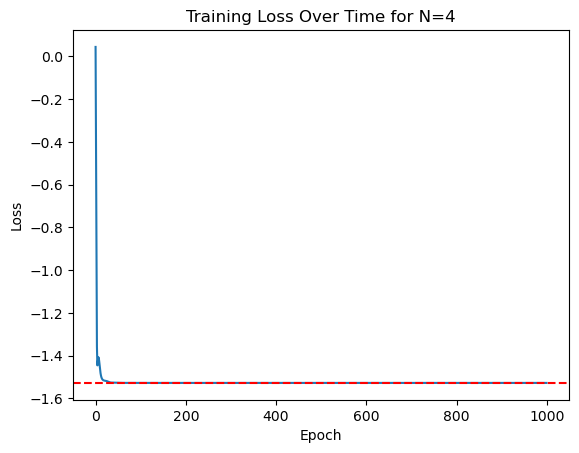

In [24]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=4')
plt.show()

### For N=5 SYK Model

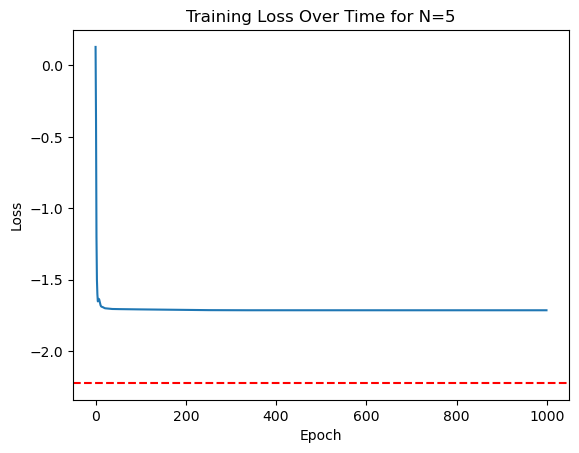

In [31]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=5')
plt.show()

### For N=8 SYK Model

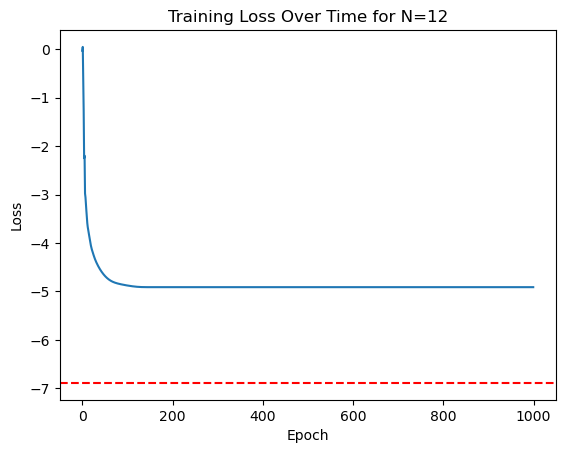

In [8]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=12')
plt.show()

## Sample VQE

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_csv('SYK_results.csv')
df

,Experiment_run,true_energy,hybrid_model_energy,difference,N
0,experiment_number_0,-5.315575,-2.777270,88.159720,8
1,experiment_number_1,-1.528238,-1.527674,0.039820,4
2,experiment_number_2,-2.745392,-2.095270,31.023244,6
3,experiment_number_3,-2.222125,-1.707276,29.687416,5
4,experiment_number_4,-5.315575,-2.825043,88.158857,8
5,experiment_number_5,-2.222125,-1.713536,29.643425,5
6,experiment_number_6,-1.528238,-1.527714,0.034272,4
7,experiment_number_7,-0.020000,0.000000,inf,2
8,experiment_number_8,-0.030000,-0.030000,0.000003,3
9,experiment_number_9,-1.528238,-1.527714,0.034271,4


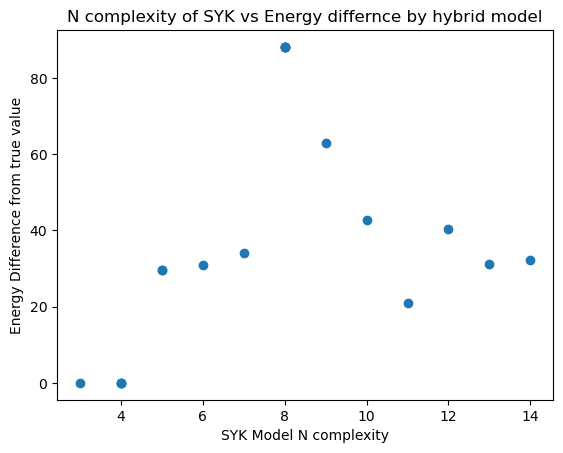

In [10]:
x= df['N']
y= df['difference']
plt.scatter(x,y)
plt.xlabel("SYK Model N complexity")
plt.ylabel("Energy Difference from true value")
plt.title("N complexity of SYK vs Energy differnce by hybrid model")
plt.show()

In [11]:
num_qubits = 8
depth = 4
num_params_per_rotation_layer = 3 * num_qubits
num_params_per_rxx_layer = num_qubits // 2
num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
total_params = depth * num_params_per_layer    

In [12]:
print(total_params)

112


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, ParameterVector

class UnifiedHybridModel(nn.Module):
    def __init__(self, input_dim, output_dim, qubits=4):
        super(UnifiedHybridModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.qubits = qubits

        # A unified parameter vector for both classical and quantum parameters
        self.params = ParameterVector('theta', length=input_dim + qubits + output_dim)

        # Classical-to-Quantum Interface: Maps input_dim to qubits
        self.pre_quantum_layer = nn.Linear(input_dim, qubits)

        # Quantum-to-Classical Interface: Maps qubits to output_dim
        self.post_quantum_layer = nn.Linear(qubits, output_dim)

    def forward(self, x):
        # Classical Encoding
        encoded = self.pre_quantum_layer(x)

        # Quantum Circuit Execution as a 'Layer'
        quantum_output = self.run_quantum_circuit(encoded)

        # Classical Decoding
        decoded = self.post_quantum_layer(quantum_output)
        return decoded

    def run_quantum_circuit(self, params):
        # Define the quantum circuit with parametrized gates
        
        qc = QuantumCircuit(self.qubits)
        paras= []
        for i in params:
            paras.append(i[0])
        for i in range(self.qubits):
            #param_value = params[i].item()
            qc.rx(float(paras[0]), i)


        # Execution and measurement
        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result().get_statevector(qc)
        
        # Process the quantum execution result
        # Note: This step may involve more sophisticated processing based on the nature of your problem
        processed_result = self.process_quantum_result(result)
        return processed_result

    def process_quantum_result(self, result):
        # Placeholder for processing the quantum result
        # Convert result to tensor or manipulate as needed
        return torch.tensor([abs(amplitude)**2 for amplitude in result], dtype=torch.float32)

# Example usage
model = UnifiedHybridModel(input_dim=10, output_dim=5).double()
input_data = torch.rand((1, 10), dtype=torch.float32)  # Example input
output = model(input_data)

# Define optimizer and loss for training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

# Example training loop (simplified)
for epoch in range(100):
    optimizer.zero_grad()
    output = model(input_data)
    loss = loss_function(output, torch.rand((1, 5), dtype=torch.float32))  # Example target
    loss.backward()
    optimizer.step()


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double